In [2]:
# https://allendowney.github.io/SurvivalAnalysisPython/02_kaplan_meier.html
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import lifelines

In [286]:
df = pd.read_csv('merged_df.csv')
df.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace=True)

In [287]:
df['date'] = pd.to_datetime(df['unixReviewTime'], unit='s')

In [288]:
df = df[['asin', 'reviewerID', 'date', 'overall']].sort_values(by='date')
df['prev_review_delta'] = df.groupby('asin')['date'].diff().dt.days
df.dropna(subset=['prev_review_delta'], inplace=True)

In [289]:
def plot_lifelines(obs):
    """Plot a line for each observation.
    
    obs: DataFrame
    """
    obs.sort_values(by='date', inplace=True)
    obs = obs.reset_index(drop=True)
    cmap = matplotlib.cm.get_cmap('Set1')
    for i, asin in enumerate(obs.asin.unique()):
        start = 0
        for j, (y, row) in enumerate(obs[obs.asin == asin].iterrows()):
    #         start = row['start']
    #         end = row['end']
    #         status = row['status']

    #         if status == 0:
    #             # ongoing
    #             plt.hlines(y, start, end, color='C0')
    #         else:
                # complete
            delay = row['prev_review_delta']
            color = cmap(i)
            plt.hlines(y, start, start+delay, color=color)
            plt.plot(start+delay, y, marker='o', color=color)
            start += delay
            
    plt.xlabel('Time (weeks)')
    plt.ylabel('Dog index')
    plt.gca().invert_yaxis()

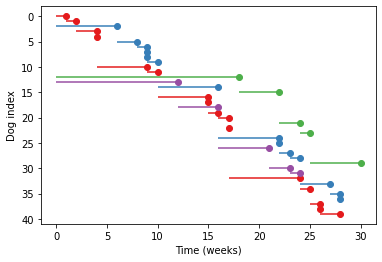

In [290]:
asins = ['B000KJVIOI', 'B000LKV7LU', 'B000G8399A', 'B000KA9I6W']
df[df.asin.isin(asins)][-50:]
plot_lifelines(df[df.asin.isin(asins)][-40:])

In [291]:
df['events'] = df.groupby(['asin','prev_review_delta'])['date'].transform('count')
df.loc[df.groupby('asin')['events'].tail(1).index, 'events'] = 0

In [292]:
df['num_subjects']=df.groupby('asin')['events'].transform('cumcount',ascending=False)+1

In [293]:
df['hazard'] = df['events']/df['num_subjects']
df['helper']=1-df['hazard']

In [294]:
df['survival']=df.groupby('asin')['helper'].transform('cumprod')
df.loc[df.groupby('asin')['survival'].head(1).index, 'survival'] = 1-df.hazard
df.drop('helper', inplace=True, axis=1)

In [295]:
df['cdf']=1-df.survival

In [296]:
df.loc[df['asin'] == 'B000PGHLNS']

asin      reviewerID       date  overall  prev_review_delta  \
153618  B000PGHLNS  A2TJVGT8VFRGHQ 2017-01-15        5             2376.0   
153617  B000PGHLNS  A1LMUHXVNBLTGZ 2017-02-11        5               27.0   
153616  B000PGHLNS  A2UANWXX8918TT 2017-02-16        5                5.0   
153615  B000PGHLNS   ARUYHWTDCL5ML 2017-05-27        1              100.0   
153614  B000PGHLNS  A11BPEYH3KRXTM 2017-06-17        5               21.0   
153613  B000PGHLNS   A6618H5A4SDP9 2017-08-16        5               60.0   
153612  B000PGHLNS   AHA54BNKLZF3D 2017-10-30        5               75.0   
153611  B000PGHLNS   ASND3TNAN1ZV6 2018-01-01        1               63.0   
153610  B000PGHLNS  A348TWKE1J75ZZ 2018-01-04        5                3.0   
153609  B000PGHLNS  A26GVKHFQHG2XV 2018-01-08        4                4.0   
153608  B000PGHLNS  A2EX3RTYDR8FUQ 2018-02-03        5               26.0   
153607  B000PGHLNS  A26C6HYXKKXC8K 2018-02-20        5               17.0   
153606  B000PGHLNS  A1KM4W2RIB8QJX 2018-03-01        3                9.0   
153605  B000PGHLNS  A3QKC8HPB1GQYY 2018-03-06        5                5.0   

        events  num_subjects    hazard  survival       cdf  
153618       1            14  0.071429  0.928571  0.071429  
153617       1            13  0.076923  0.857143  0.142857  
153616       2            12  0.166667  0.714286  0.285714  
153615       1            11  0.090909  0.649351  0.350649  
153614       1            10  0.100000  0.584416  0.415584  
153613       1             9  0.111111  0.519481  0.480519  
153612       1             8  0.125000  0.454545  0.545455  
153611       1             7  0.142857  0.389610  0.610390  
153610       1             6  0.166667  0.324675  0.675325  
153609       1             5  0.200000  0.259740  0.740260  
153608       1             4  0.250000  0.194805  0.805195  
153607       1             3  0.333333  0.129870  0.870130  
153606       1             2  0.500000  0.064935  0.935065  
153605       0             1  0.000000  0.064935  0.935065

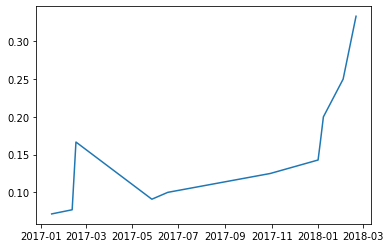

In [308]:
plt.plot(df.loc[df['asin'] == 'B000PGHLNS'].date[0:-2], df.loc[df['asin'] == 'B000PGHLNS'].hazard[0:-2])

In [337]:
def plot_model(item):
    model = lifelines.KaplanMeierFitter()
    model.fit(df.loc[df['asin'] == item].prev_review_delta, df.loc[df['asin'] == item].events)
    ci = model.confidence_interval_survival_function_
    ts = ci.index
    low, high = np.transpose(ci.values)

    plt.fill_between(ts, low, high, color='gray', alpha=0.3)
    model.survival_function_.plot(ax=plt.gca())
    plt.ylabel('Survival function');

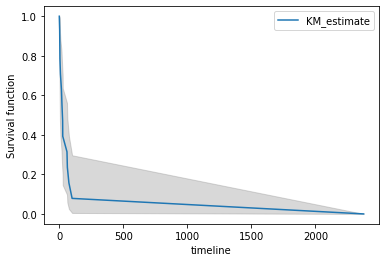

In [338]:
plot_model('B000PGHLNS')

In [364]:
cox = lifelines.CoxPHFitter()
km = lifelines.KaplanMeierFitter()

In [356]:
from lifelines.datasets import load_rossi
rossi_dataset = load_rossi()
rossi_dataset

week  arrest  fin  age  race  wexp  mar  paro  prio
0      20       1    0   27     1     0    0     1     3
1      17       1    0   18     1     0    0     1     8
2      25       1    0   19     0     1    0     1    13
3      52       0    1   23     1     1    1     1     1
4      52       0    0   19     0     1    0     1     3
..    ...     ...  ...  ...   ...   ...  ...   ...   ...
427    52       0    1   31     0     1    0     1     3
428    52       0    0   20     1     0    0     1     1
429    52       0    1   20     1     1    1     1     1
430    52       0    0   29     1     1    0     1     3
431    52       0    1   24     1     1    0     1     1

[432 rows x 9 columns]

In [354]:
km.fit(temp.iloc[: , 3:], event_col='events', duration_col='prev_review_delta')

C:\Users\Frede\anaconda3\lib\site-packages\lifelines\fitters\coxph_fitter.py:1524: LinAlgWarning: Ill-conditioned matrix (rcond=2.87718e-17): result may not be accurate.
  inv_h_dot_g_T = spsolve(-h, g, assume_a="pos", check_finite=False)
C:\Users\Frede\anaconda3\lib\site-packages\lifelines\fitters\coxph_fitter.py:1524: LinAlgWarning: Ill-conditioned matrix (rcond=3.52085e-17): result may not be accurate.
  inv_h_dot_g_T = spsolve(-h, g, assume_a="pos", check_finite=False)
C:\Users\Frede\anaconda3\lib\site-packages\lifelines\fitters\coxph_fitter.py:1524: LinAlgWarning: Ill-conditioned matrix (rcond=1.77116e-17): result may not be accurate.
  inv_h_dot_g_T = spsolve(-h, g, assume_a="pos", check_finite=False)


ConvergenceError: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.